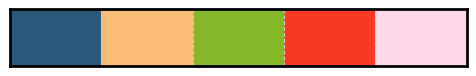

In [1]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

In [38]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    custom_palette = {'Zest-all': '#FABC75', 'Zest-saved': '#F83A25', 'GEX-all': '#2A587A'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm', 
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette, 
                            width=width, linewidth=1.0, order=x_order, common_norm=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)
        
    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance from Parent Input (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [3]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [4]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index 
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [5]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices) 
    return stats_df

# RQ1: How destructive are Zest's mutations in general? Are disruptive mutations beneficial for fuzzing?

In [6]:
experiment_name1 = 'ei-d430-m1'
experiment_name2 = 'ei-d430-m2'
process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name1), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation1')
process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name2), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation2')
# load the df from pickle
mutation_df1 = pd.read_pickle('./mutation1.pkl')
mutation_df2 = pd.read_pickle('./mutation2.pkl')
mutation_df = pd.concat([mutation_df1, mutation_df2], ignore_index=True, sort=False)
mutation_df.to_pickle('./mutation.pkl')

processing ant...
processing maven...
processing rhino...
processing closure...
processing chocopy...
processing gson...
processing jackson...
creating dataframe...
processing ant...
processing maven...
processing rhino...
processing closure...
processing chocopy...
processing gson...
processing jackson...
creating dataframe...


In [7]:
experiment_name = 'v_dec10'
mutation_df = pd.read_pickle('./mutation.pkl')

In [8]:
new_label_names = {'zest-testWithGenerator': 'Zest-all', 'zest-testWithGenerator-saved_only': 'Zest-saved', 'ei-no-havoc-testWithGenerator': 'GEX-all', 'ei-no-havoc-testWithGenerator-saved_only': 'GEX-saved'}
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
print(mutation_df['algorithm'].unique())

['Zest-all' 'Zest-saved' 'GEX-all' 'GEX-saved']


In [9]:
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]
print(all_input_df.benchmark_name.unique())

['ant' 'maven' 'rhino' 'closure' 'chocopy' 'gson' 'jackson']


In [28]:
non_zero_mutation_df = mutation_df[mutation_df['mutation'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]

/tmp/ipykernel_1330106/3758107138.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_1330106/3758107138.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


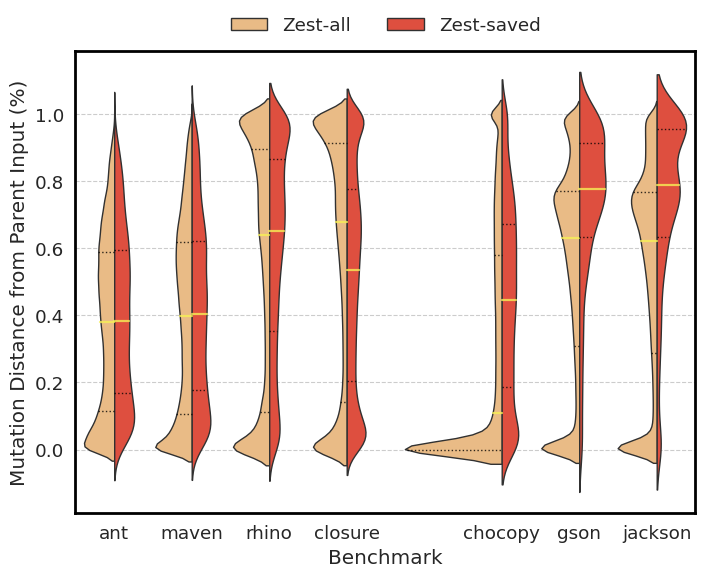

In [36]:
# zest all inputs vs. zest saved inputs
x_order = ('ant', 'maven', 'rhino', 'closure', 'NA1', 'chocopy', 'gson', 'jackson')
violin_plot_for_mutation_distance(zest_df, experiment_name, 'rq1_zest_all_vs_saved', width=2.5, x_order=x_order)

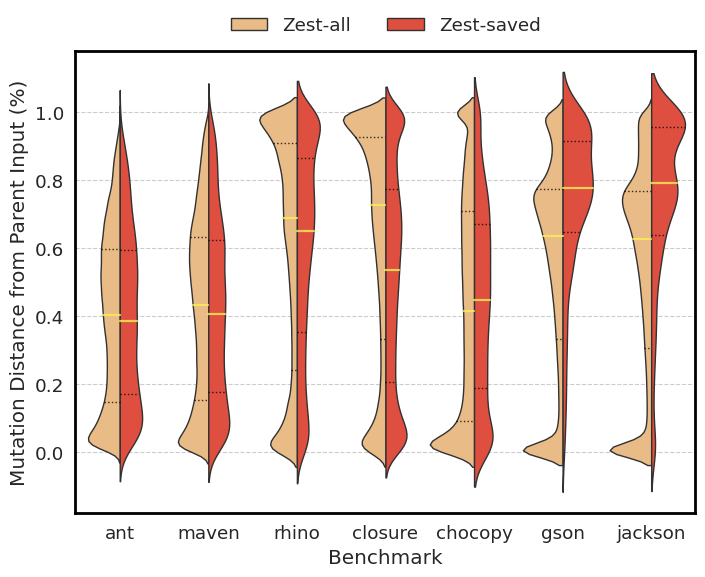

In [35]:
violin_plot_for_mutation_distance(non_zero_zest_df, experiment_name, 'rq1_wo_zero_mutations', width=1.0)

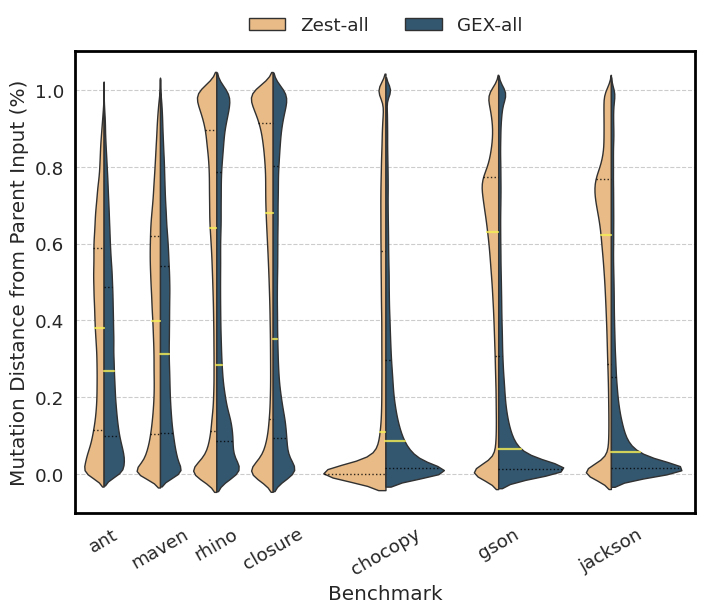

In [41]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'NA1', 'chocopy', 'NA2', 'gson', 'NA3', 'jackson', 'NA4')
violin_plot_for_mutation_distance(all_input_df, experiment_name, 'rq2_zest_vs_ei', width=2.5, x_order=x_order)

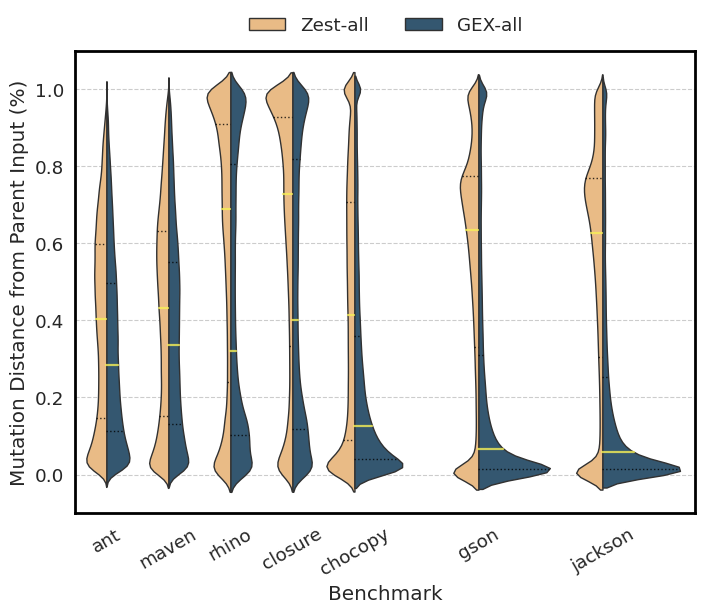

In [43]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'chocopy', 'NA1', 'gson', 'NA2', 'jackson', 'NA3')
violin_plot_for_mutation_distance(non_zero_all_input_df, experiment_name, 'rq2_wo_zero_mutations', x_order=x_order, width=2.5)

In [13]:
# stats table 
groupby = all_input_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
all_input_stats = beautify_stats_table(groupby)
all_input_stats
# bar_plot_for_median_mutation_distance(all_input_stats, experiment_name, 'all_input_bar_plot')
# box_plot_for_mutation_distance(zest_df, experiment_name, 'zest_box_plot')

algorithm benchmark_name   mutation                                     \
                                 count    median      mean       std  min   
0    GEX-all            ant  1000000.0  0.268293  0.311858  0.239864  0.0   
1    GEX-all        chocopy  1000000.0  0.085714  0.205313  0.263733  0.0   
2    GEX-all        closure  1000000.0  0.352459  0.434631  0.357525  0.0   
3    GEX-all           gson  1000000.0  0.065390  0.217223  0.296558  0.0   
4    GEX-all        jackson  1000000.0  0.057953  0.190841  0.267425  0.0   
5    GEX-all          maven  1000000.0  0.312000  0.343703  0.260139  0.0   
6    GEX-all          rhino  1000000.0  0.282609  0.411665  0.357830  0.0   
7   Zest-all            ant  1000000.0  0.380531  0.373124  0.262650  0.0   
8   Zest-all        chocopy  1000000.0  0.110294  0.293360  0.336459  0.0   
9   Zest-all        closure  1000000.0  0.679245  0.567409  0.370488  0.0   
10  Zest-all           gson  1000000.0  0.630600  0.540479  0.315079  0.0   
11  Zest-all        jackson  1000000.0  0.621951  0.530217  0.313515  0.0   
12  Zest-all          maven  1000000.0  0.398782  0.387303  0.281739  0.0   
13  Zest-all          rhino  1000000.0  0.639774  0.540594  0.372511  0.0   

              
         max  
0   0.982568  
1   1.000000  
2   1.000000  
3   0.999663  
4   0.999656  
5   0.995632  
6   1.000000  
7   0.988689  
8   1.000000  
9   1.000000  
10  0.999675  
11  0.999654  
12  0.996517  
13  1.000000